In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import scipy

plt.rcParams['image.cmap']='cividis'

c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]

import sscCdi
sscCdi.__version__

'0.8.10'

### INPUTS

In [12]:
# SIEMENS BIG FOV
# path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_square/raw/ptycho_z1_50_z1z2_1000_032.hdf5'
path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_square/raw/ptycho_z1_50_z1z2_1000_com_flat_dark_22_e_39kev_043.hdf5'
# path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_square/raw/ptycho_z1_50_z1z2_1000_com_flat_dark_39kev_039.hdf5'
z1 = 50*1e-3

# GOLGI
# path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_golgi/raw/ptycho_amostra_murilo_z1_500_z1z2_1000_com_flat_dark_22_e_39kev_005.hdf5'
# z1 = 500e-3

# ROCHA
# path = "/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_golgi/raw/ptycho_amostra_rocha_petro_z1_500_z1z2_1000_com_flat_dark_22_e_39kev_008.hdf5"
# z1 = 500e-3

z1z2 =  0.98 # z1+z2 # source to detector

((399, 2048, 2048), (400, 2))

### READ DATA


In [ ]:
data = h5py.File(path, 'r')
flatfield = data['scan/detector/flats'][()][0]
dark = data['scan/detector/darks'][()][0]
DPs = data['scan/detector/data'][()]
DPs[:] -= dark

positions = data['scan/detector/positions'][()][:,0:2]*1e-3 # convert to meters

DPs.shape, positions.shape

### ADJUST PARAMETERS

In [14]:
z2 = z1z2 - z1
M = (z2+z1)/z1

n_pixels = 2048
inputs = {
"n_cpus": 32, # cpu cores
"energy": 22, #keV
"detector_distance": z2/M, # meter
"detector_pixel_size": 1.44e-6/M,
"source_distance": 0, # should be 0 if parallel beam
"iterations": 10,
"fresnel_regime": True,
"probe_support": None,
"incoherent_modes": 1,
"beta": 0.9, # RAAR beta
"epsilon":0.001, # RAAR; small value to add to probe/object update denominator
"object_padding": 200, # border pixels to guarantee enough FOV during scan
}

inputs["wavelength"] = c_speed * planck / inputs["energy"]
inputs['object_pixel'] = inputs["detector_pixel_size"] # if not using /M for the detector pixel size above, /M should be included here
print(f'Object pixel = {inputs["object_pixel"]} m')

positions = sscCdi.convert_probe_mogno_positions_meters_to_pixels(positions.copy(),inputs["object_pixel"],inputs["object_padding"])

if 0: # remove random points from data
    n_of_points_to_keep = 100
    start_idx = positions0.shape[0] - n_of_points_to_keep
    slices_to_ignore = np.random.permutation(positions.shape[0])[-start_idx::]
    print(f'Deleting {slices_to_ignore.shape[0]} slices')
    DPs = np.delete(DPs,slices_to_ignore,axis=0)
    positions = np.delete(positions,slices_to_ignore,axis=0)

size_in_bytes = DPs.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

inputs = sscCdi.set_object_shape(inputs, DPs.shape, positions)
inputs["object_shape"] = (inputs["object_shape"][1],inputs["object_shape"][0])
print(f'Object shape = {inputs["object_shape"]}')

print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions.shape}')

model_object = np.ones(inputs["object_shape"])

probe_guess = np.ones_like(DPs[0]) + 1j
probe_guess = probe + 1j
obj_guess = np.ones_like(model_object) + 1j # constant object

print(f"Probe guess: {probe_guess.shape}")
print(f"Obj guess: {obj_guess.shape}")

inputs

Object pixel = 7.346938775510205e-08 m
Probe shape = (2048, 2048)
Size of the array: 3.1171875 GB
Object shape = (3280, 3281)
Data shape = (399, 2048, 2048)
Positions shape = (399, 2)
Probe guess: (2048, 2048)
Obj guess: (3280, 3281)


{'n_cpus': 32,
 'energy': 22,
 'detector_distance': 0.047448979591836735,
 'detector_pixel_size': 7.346938775510205e-08,
 'source_distance': 0,
 'iterations': 10,
 'fresnel_regime': True,
 'probe_support': None,
 'incoherent_modes': 1,
 'beta': 0.9,
 'epsilon': 0.001,
 'object_padding': 200,
 'wavelength': 5.6356453357367875e-11,
 'object_pixel': 7.346938775510205e-08,
 'object_shape': (3280, 3281)}

### CALL PTYCHOGRAPHY

In [15]:
%matplotlib widget
sscCdi.misc.deploy_visualizer(DPs,type='abs',title='CC',cmap='gray',axis=0, limits=(0,30000)) # select axis

In [28]:
RAAR_obj, RAAR_probes, RAAR_error = sscCdi.ptycho.raar.RAAR_multiprobe_cupy(DPs,positions,obj_guess,probe_guess,inputs)
propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"],inputs["source_distance"]) 

RAAR_obj.shape, RAAR_probes.shape

	Iteration 10/10 	Error: 1.03e-01

((3280, 3281), (1, 2048, 2048))

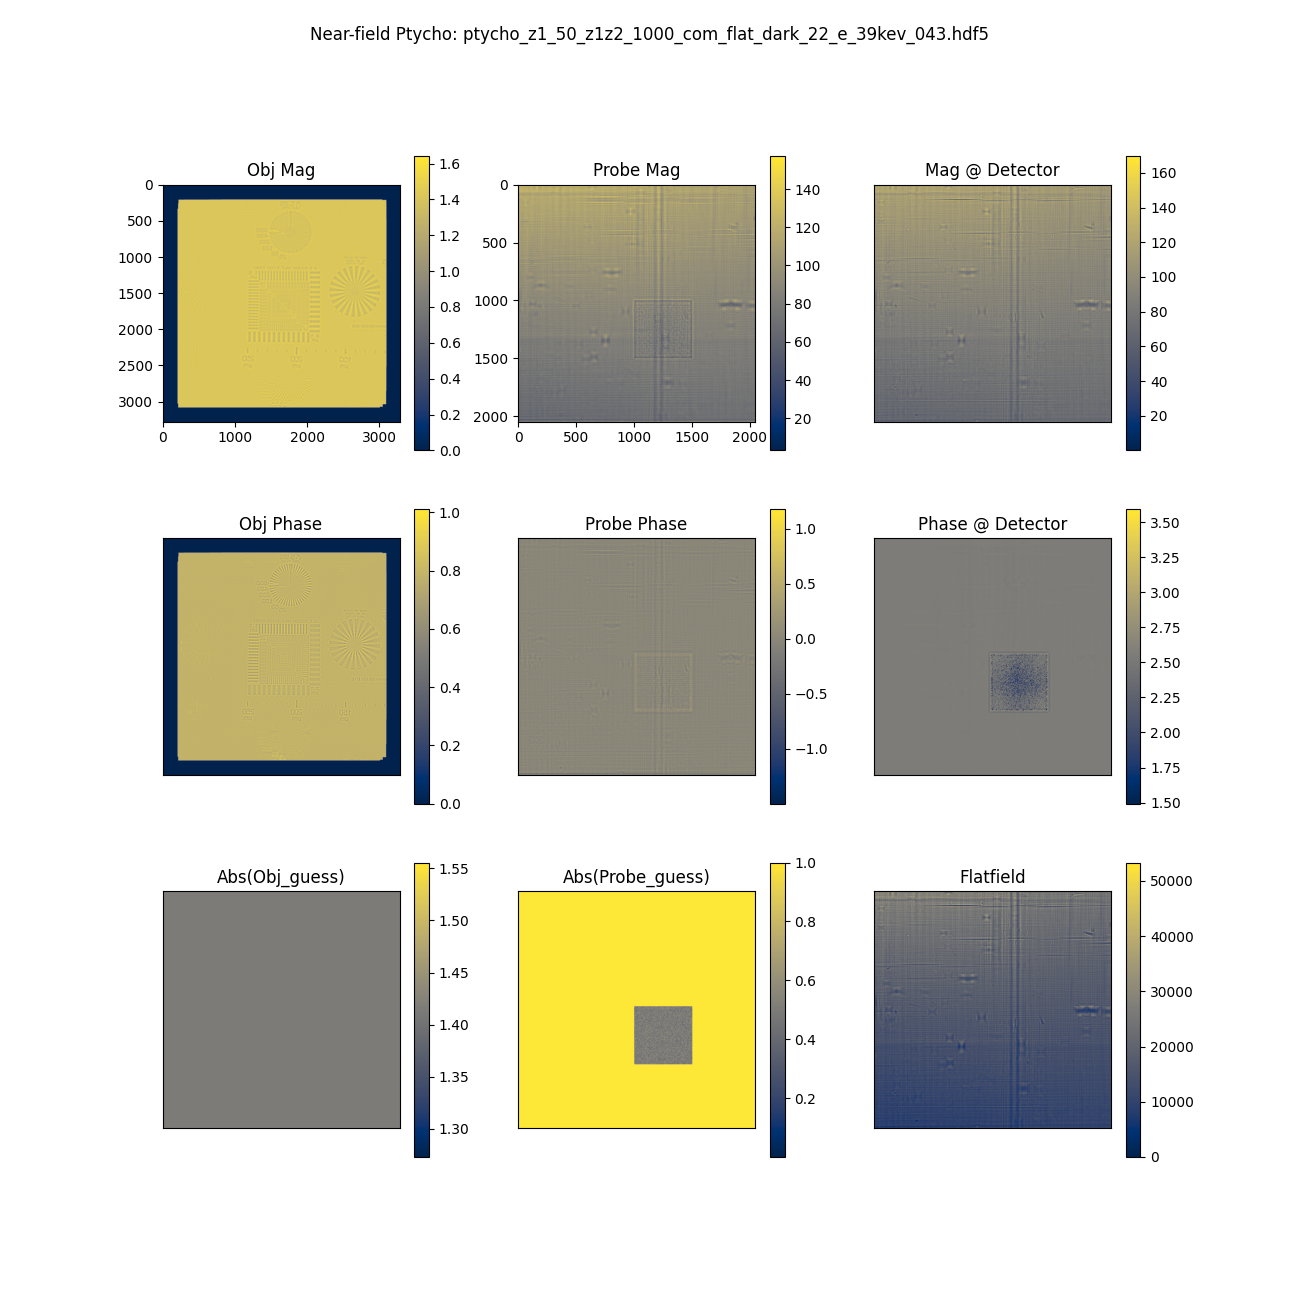

In [29]:
fig, ax = plt.subplots(3,3,figsize=(13,13),dpi=100)

im1=ax[0,0].imshow(np.abs(RAAR_obj))
ax[0,0].set_title('Obj Mag')
# ax[0,0].plot(positions[:,0],positions[:,1],'.',color='gray')
fig.colorbar(im1, ax=ax[0, 0])

im2 = ax[1,0].imshow(np.angle(RAAR_obj))
ax[1,0].set_title('Obj Phase')
fig.colorbar(im2, ax=ax[1, 0])

im3 = ax[0,1].imshow(np.abs(RAAR_probes[0]))
ax[0,1].set_title('Probe Mag')
fig.colorbar(im3, ax=ax[0, 1])

im4 = ax[1,1].imshow(np.angle(RAAR_probes[0]))
ax[1,1].set_title('Probe Phase')
fig.colorbar(im4, ax=ax[1, 1])

im5=ax[0,2].imshow(np.abs(propagated_probe))
ax[0,2].set_title('Mag @ Detector')
fig.colorbar(im5, ax=ax[0, 2])

mean = np.mean(np.angle(propagated_probe))
std=np.std(np.angle(propagated_probe))
im6 = ax[1,2].imshow(np.angle(propagated_probe),vmin=mean-4*std,vmax=mean+4*std)
ax[1,2].set_title('Phase @ Detector')
fig.colorbar(im6, ax=ax[1,2])

im7 = ax[2,0].imshow(np.abs(obj_guess))
ax[2,0].set_title('Abs(Obj_guess)')
fig.colorbar(im7, ax=ax[2, 0])

im8 = ax[2,1].imshow(np.abs(probe_guess))
ax[2,1].set_title('Abs(Probe_guess)')
fig.colorbar(im8, ax=ax[2, 1])

im9 = ax[2,2].imshow(flatfield)
ax[2,2].set_title('Flatfield')
fig.colorbar(im9, ax=ax[2, 2])


fig.suptitle(f'Near-field Ptycho: {path.split("/")[-1]}')

for i, ax in enumerate(ax.ravel()):
    if i==1 or i==0: continue
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
# np.save("object.npy",RAAR_obj)
# np.save("probe.npy",RAAR_probes)
# np.save("probe_propagated.npy",propagated_probe)

In [ ]:
# inputs["regularization_object"] = 0.25
# inputs["regularization_probe"] = 0.5
# inputs["step_object"] = 0.7
# inputs["step_probe"] = 0.5

# inputs["friction_object"] = 0.9
# inputs["friction_probe"] = 0.99
# inputs["momentum_counter"] = 10
# inputs["use_mPIE"] = False
# PIE_obj, PIE_probes, PIE_error = sscCdi.PIE_multiprobe_loop(DPs, positions,obj_guess,probe_guess,inputs)

# propagated_probe_PIE = sscCdi.fresnel_propagator_cone_beam(PIE_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],z2/M,0) 

# propagated_probe_PIE /= np.max(propagated_probe_PIE)

# fig, ax = plt.subplots(2,4,figsize=(13,8),dpi=100)
# ax[0,0].imshow(np.abs(PIE_obj[0])), ax[0,0].set_title('Obj Mag')
# ax[0,0].plot(positions[:,0],positions[:,1],'.',color='r')
# ax[0,1].imshow(np.angle(PIE_obj[0])), ax[0,1].set_title('Obj Phase')
# ax[0,2].imshow(np.abs(empty),vmax=6000), ax[0,2].set_title('Flat')
# ax[1,0].imshow(np.abs(PIE_probes[0])), ax[1,0].set_title('Probe Mag')
# ax[1,1].imshow(np.angle(PIE_probes[0])), ax[1,1].set_title('Probe Phase')
# ax[1,2].imshow(np.abs(propagated_probe_PIE)), ax[1,2].set_title('Mag Propagated')
# ax[1,3].imshow(np.angle(propagated_probe_PIE)), ax[1,3].set_title('Phase Propagated')
# ax[0,3].plot(PIE_error,'o-',label='Error')
# ax[0,3].set_xlabel('Iterations')
# ax[0,3].legend(), ax[0,3].grid()

# for i, ax in enumerate(ax.ravel()):
#     if i==3 or i==0 or i ==4: continue
#     ax.set_xticks([])
#     ax.set_yticks([])